In [2]:
import xarray as xr
import ast
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd
import cartopy.crs as ccrs
from matplotlib.patches import PathPatch
import gsw

In [3]:
with open("eddyCenterpoints_fullYear.txt",'r') as f:
        data = f.read()
        eddyLocation = ast.literal_eval(data)


eddy_df = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/Eddies_fullYear.nc')['EddyDetection']
eddy_area = eddy_df.where(eddy_df != 4, other=np.nan)

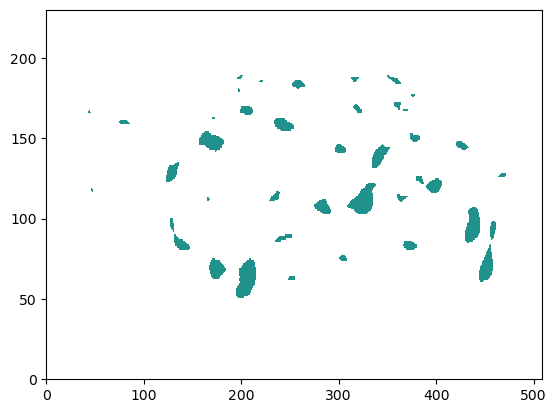

In [4]:
plt.contourf(eddy_area[0],[1.5,2])

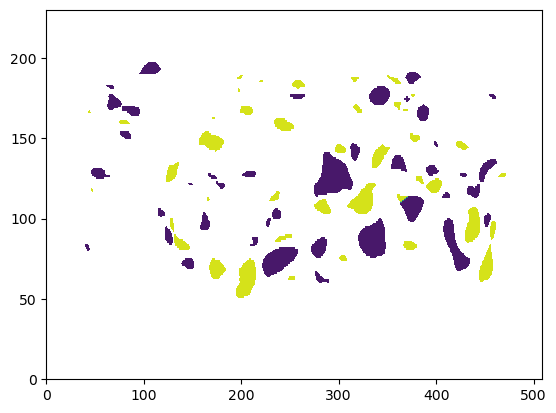

In [5]:
plt.contourf(eddy_area[0])

In [6]:
locMax = pd.read_csv('/nird/projects/NS9608K/MSc_EK/Data/locMAX2.csv')
locMin = pd.read_csv('/nird/projects/NS9608K/MSc_EK/Data/locMin2.csv')

depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(71,73.5)).sel(X=slice(-18,-3))
depth_no_nan = depth
depth = depth.where(depth > 0, np.nan)

FWC = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/FWC_full_domain.nc')['__xarray_dataarray_variable__'].sel(Y=slice(71,73.5)).sel(X=slice(-18,-3))
FWC = FWC.resample(time='D').mean(dim='time')

In [ ]:
x = np.unique([0,2,0,3,np.nan])
x = x[~np.isnan(x)]
print(x[1])
print(len([1]))

2.0
Number of eddies:  1


In [25]:
display(locMax,locMin)
print('Number of eddies: ',len(locMax)+len(locMin), ' Warm: ',len(locMax),' Cold: ',len(locMin))

,Time,ID,Latitude,Longitude
0,0,1.0,71.079446,-9.051356
1,0,2.0,71.241831,-14.804034
2,0,3.0,71.278327,-10.910303
3,0,4.0,71.370250,-2.622462
4,0,5.0,71.407301,-19.715016
...,...,...,...,...
13189,364,2690.0,73.281687,-17.847658
13190,364,2790.0,73.330735,-15.751358
13191,364,2821.0,73.430090,-12.556844
13192,364,2789.0,73.505746,-4.653370


,Time,ID,Latitude,Longitude
0,0,2812.0,71.079446,-10.219283
1,0,2813.0,71.151252,-12.122169
2,0,2814.0,71.187372,-13.562805
3,0,2815.0,71.187372,-1.030822
4,0,2816.0,71.296632,-7.875797
...,...,...,...,...
13670,364,6719.0,73.233045,-6.419260
13671,364,6625.0,73.634121,-19.362781
13672,364,6735.0,73.634121,-3.390658
13673,364,6730.0,73.686302,-5.157537


Number of eddies:  26869  Warm:  13194  Cold:  13675


In [9]:
ID_locMax = [[[0,[1,1]],[1,[1,1]]]]
pre_IDs = [X[0] for X in ID_locMax[-1]]
display(pre_IDs)
a = np.unique([np.nan])
a = a[~np.isnan(a)]
if any(ID in a for ID in pre_IDs):
    print('Yes')

[0, 1]

In [10]:
eddies_ID_max_t = locMax.set_index(['Time'])
eddies_ID_min_t = locMin.set_index(['Time'])

In [11]:
locMin

,Time,ID,Latitude,Longitude
0,0,2812.0,71.079446,-10.219283
1,0,2813.0,71.151252,-12.122169
2,0,2814.0,71.187372,-13.562805
3,0,2815.0,71.187372,-1.030822
4,0,2816.0,71.296632,-7.875797
...,...,...,...,...
13670,364,6719.0,73.233045,-6.419260
13671,364,6625.0,73.634121,-19.362781
13672,364,6735.0,73.634121,-3.390658
13673,364,6730.0,73.686302,-5.157537


In [12]:
eddies_ID_max_t.at[1,'Longitude'].values

array([ -8.96461564,  -2.28099481, -14.80403419,  -8.92122919,
        -6.50835964, -15.84246337,  -2.96057022, -14.04788965,
        -1.03082195, -10.82391071,  -4.74543939,  -1.68720939,
       -14.89357792,  -8.39961177, -18.1839353 , -13.69480996,
       -11.94864493,  -2.03491948,  -3.72180824,  -5.29413407,
        -0.72285905,  -7.34921557, -17.89550644,  -4.51491494,
       -17.46707308,  -4.2366966 ,  -6.81927951, -18.62108917,
        -9.83043836,  -6.24068902,  -4.74543939,  -6.28537936,
       -16.71681008])

/tmp/ipykernel_1273810/678507274.py:32: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in contour.collections:
/tmp/ipykernel_1273810/678507274.py:60: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in contour.collections:


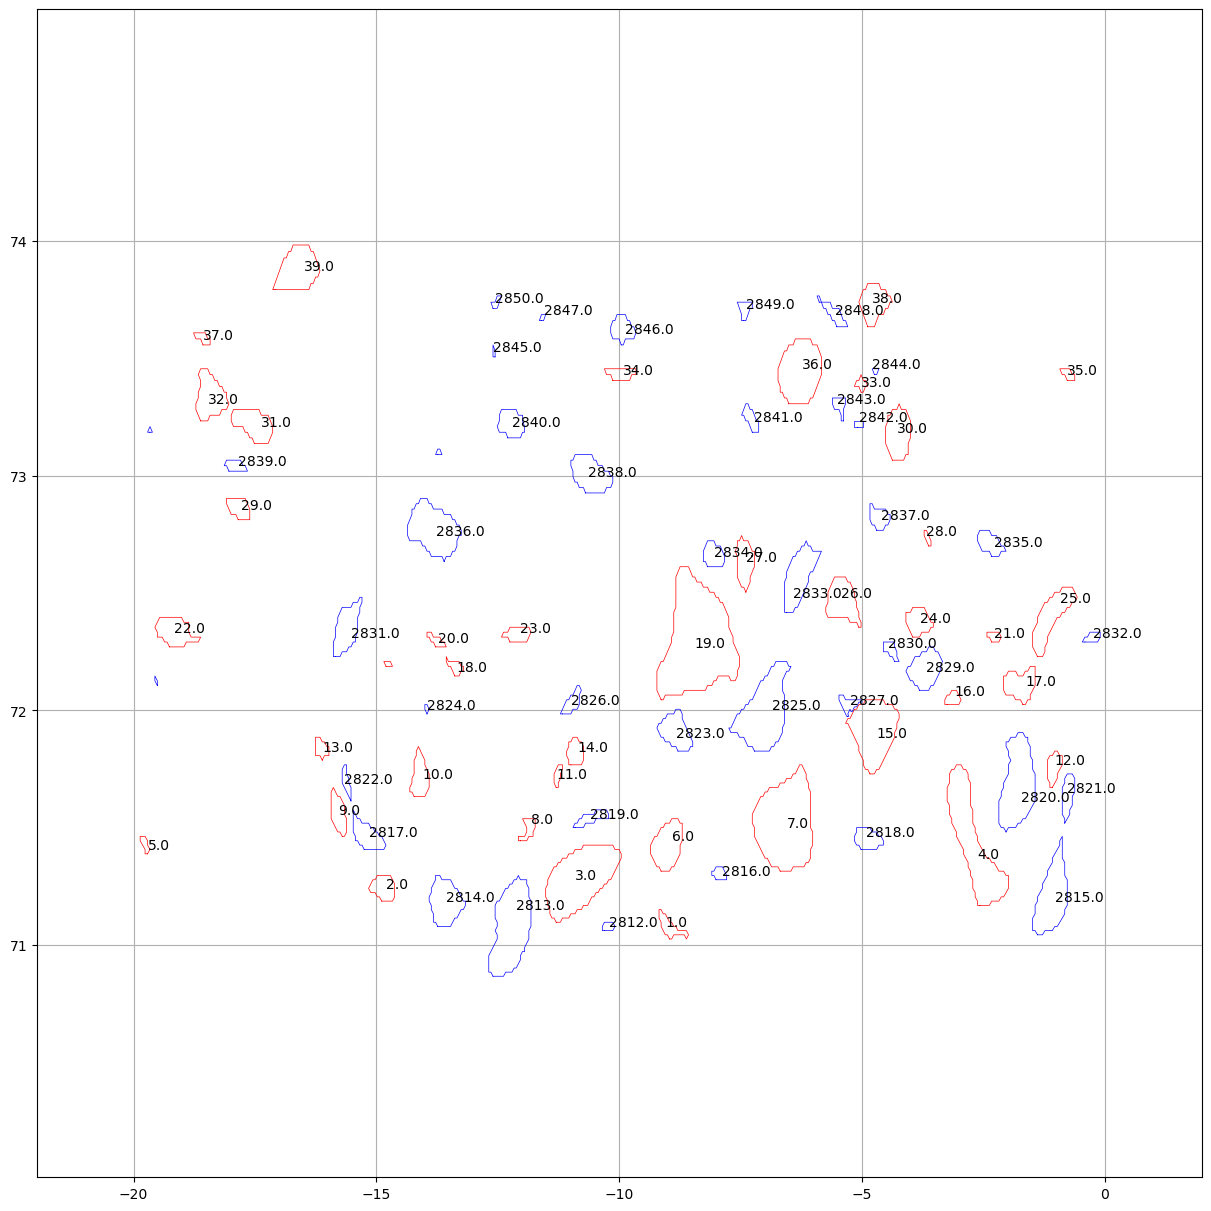

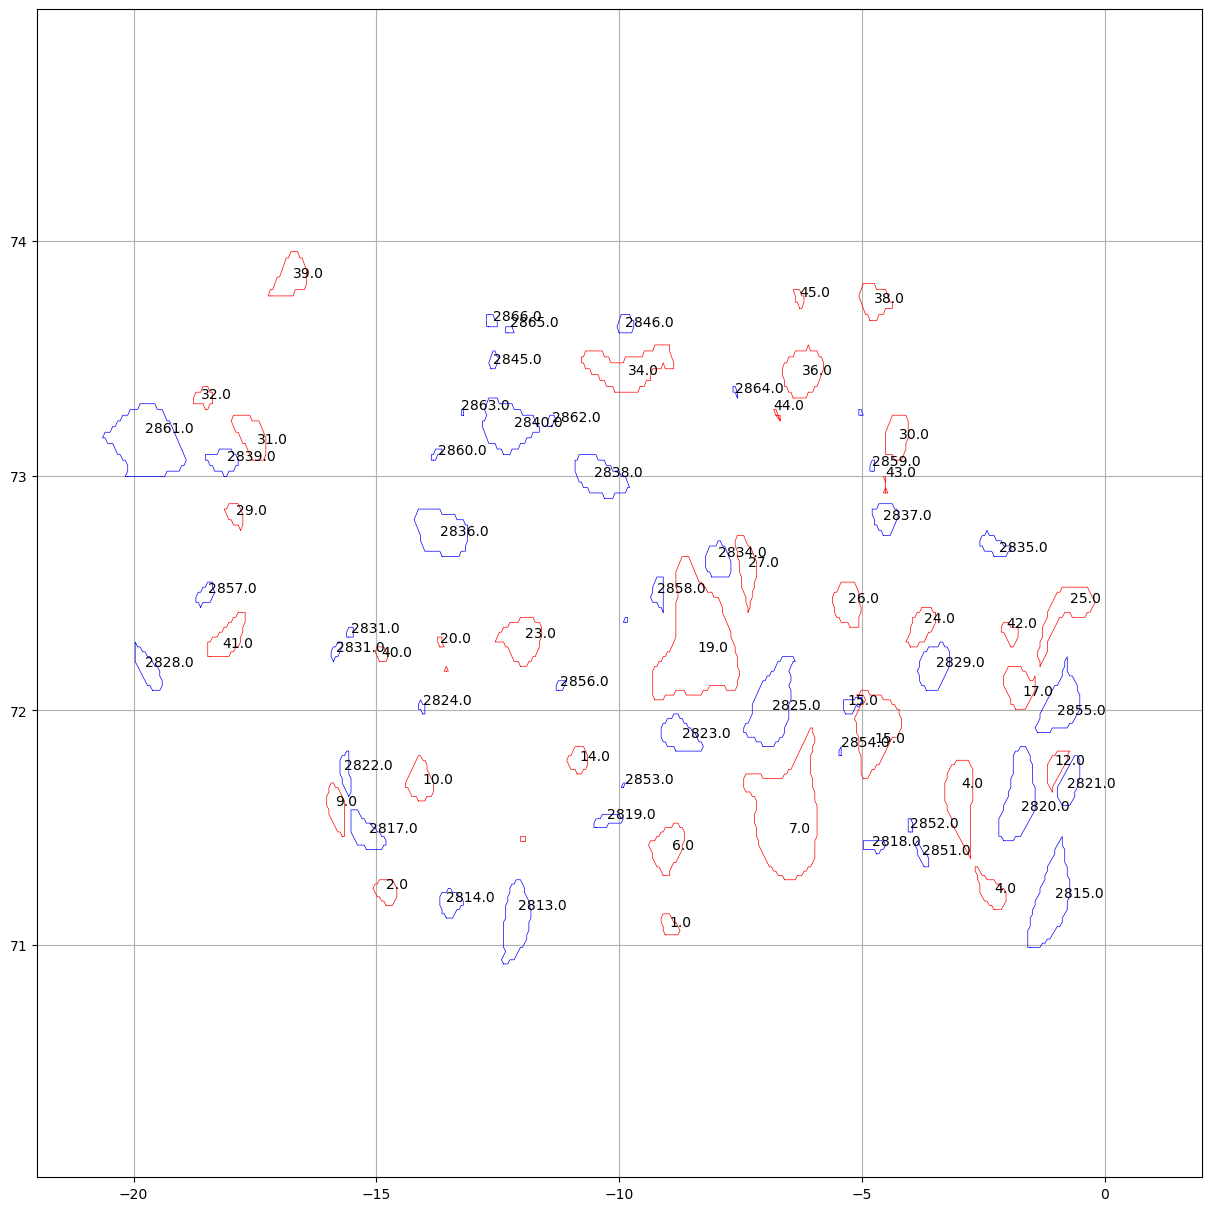

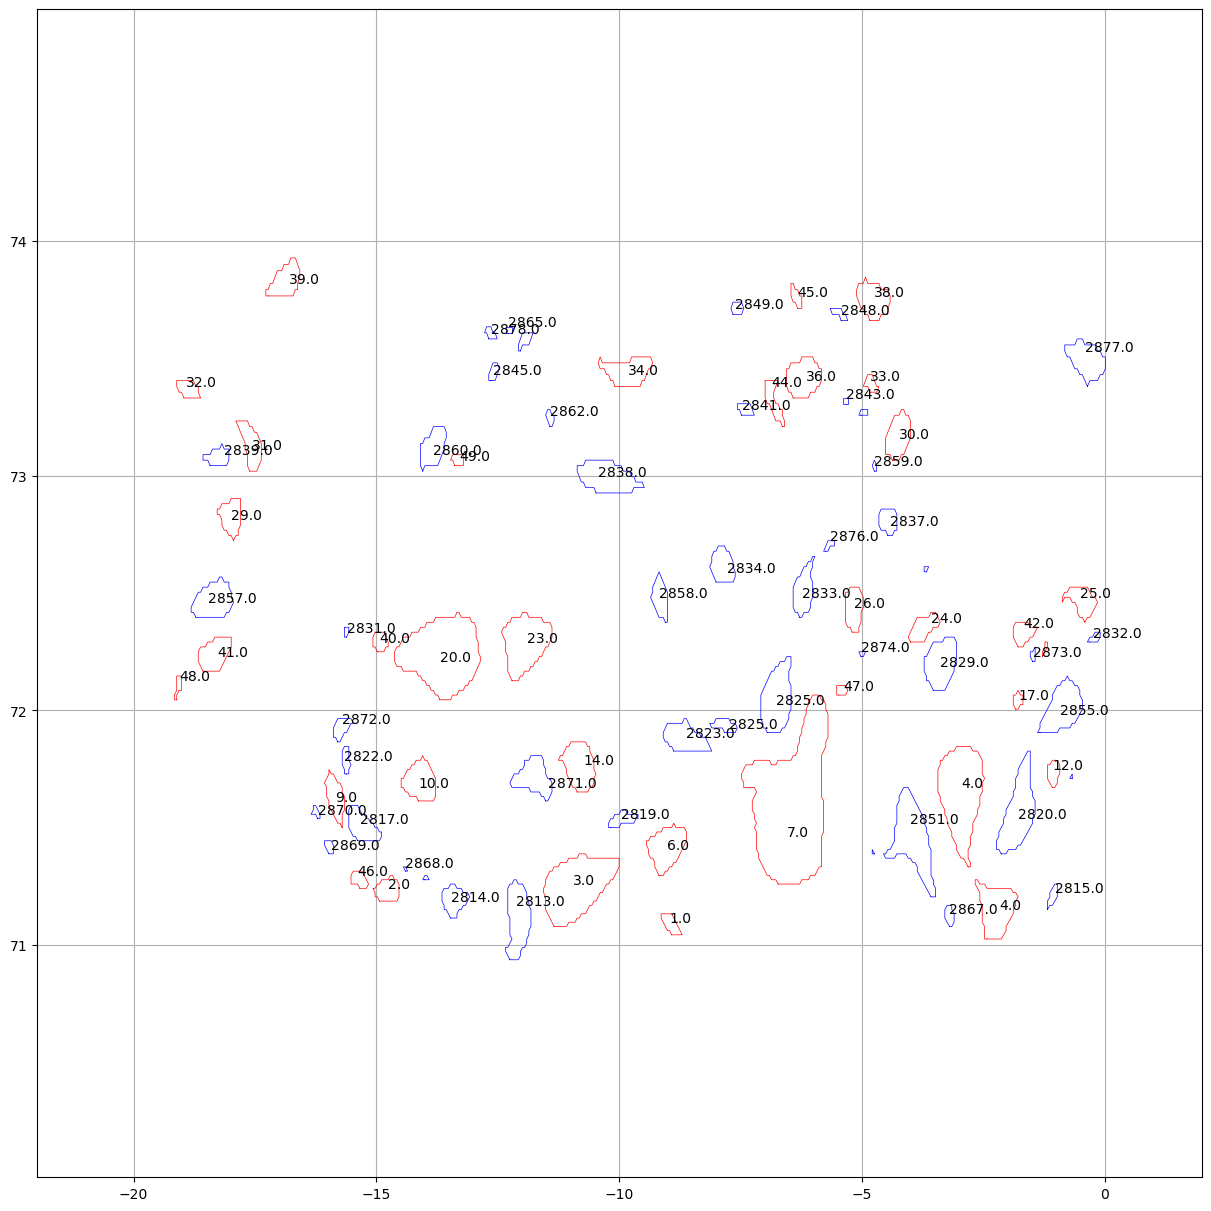

In [13]:
def is_closed_contour(vertices, tol=1e-5):
                distance = np.linalg.norm(vertices[0] - vertices[-1])
                return distance < tol


# Process Contour Paths to Handle Jumps
def process_contour_path(vertices, jump_threshold=0.2):
    segments = []
    current_segment = [vertices[0]]
    
    for i in range(1, len(vertices)):
        if np.linalg.norm(vertices[i] - vertices[i-1]) > jump_threshold:
            segments.append(np.array(current_segment))
            current_segment = [vertices[i]]
        else:
            current_segment.append(vertices[i])
    
    if current_segment:
        segments.append(np.array(current_segment))
    
    return segments

time_ = np.arange(0,3)
for time in time_:
    fig, ax = plt.subplots(
        figsize=(12,12),layout='constrained'
    )
    contour = ax.contourf(eddy_area.X,eddy_area.Y,eddy_area[time],[0,1],colors='white')
    ax.grid()
    all_contour_points = []

    for collection in contour.collections:
        for path in collection.get_paths():
            # Collect the vertices of the path
            vertices = path.vertices
            all_contour_points.append(vertices)

    processed_contour_segments = []
    for vertices in all_contour_points:
        segments = process_contour_path(vertices)
        processed_contour_segments.extend(segments)
    
    for vertices in processed_contour_segments:
        ax.plot(vertices[:, 0], vertices[:, 1], 'r-', linewidth=0.5)


    data_ID = eddies_ID_max_t.at[time,'ID'].values
    data_LON = eddies_ID_max_t.at[time,'Longitude'].values
    data_LAT = eddies_ID_max_t.at[time,'Latitude'].values
    for i in range(len(data_ID)):
        for vertices in processed_contour_segments:
            region = Path(vertices)
            if region.contains_point((data_LON[i],data_LAT[i])):
                ax.annotate(str(data_ID[i]),[data_LON[i],data_LAT[i]])
    
    contour = ax.contourf(eddy_area.X,eddy_area.Y,eddy_area[time],[1.5,2],colors='white')

    all_contour_points = []

    for collection in contour.collections:
        for path in collection.get_paths():
            # Collect the vertices of the path
            vertices = path.vertices
            all_contour_points.append(vertices)

    processed_contour_segments = []
    for vertices in all_contour_points:
        segments = process_contour_path(vertices)
        processed_contour_segments.extend(segments)
    
    for vertices in processed_contour_segments:
        ax.plot(vertices[:, 0], vertices[:, 1], 'b-', linewidth=0.5)

    data_ID = eddies_ID_min_t.at[time,'ID'].values
    data_LON = eddies_ID_min_t.at[time,'Longitude'].values
    data_LAT = eddies_ID_min_t.at[time,'Latitude'].values
    for i in range(len(data_ID)):
        for vertices in processed_contour_segments:
            region = Path(vertices)
            if region.contains_point((data_LON[i],data_LAT[i])):
                ax.annotate(str(data_ID[i]),[data_LON[i],data_LAT[i]])

In [14]:
display(eddies_ID_min_t)

,ID,Latitude,Longitude
Time,,,
0,2812.0,71.079446,-10.219283
0,2813.0,71.151252,-12.122169
0,2814.0,71.187372,-13.562805
0,2815.0,71.187372,-1.030822
0,2816.0,71.296632,-7.875797
...,...,...,...
364,6719.0,73.233045,-6.419260
364,6625.0,73.634121,-19.362781
364,6735.0,73.634121,-3.390658


In [15]:
display(locMin['ID'].values)

array([2812., 2813., 2814., ..., 6735., 6730., 6379.])

In [16]:
max_id_min = int(np.max(locMin['ID']))
max_id_max = int(np.max(locMax['ID']))



# Create the Days array with integer max_id
Days_max = np.zeros(max_id_max)
Days_min = np.zeros(max_id_min-max_id_max)
for ID in locMax['ID']:
    Days_max[int(ID)-1] += 1
for ID in locMin['ID']:
    Days_min[int(ID)-1-max_id_max] += 1

In [18]:
display(Days_max,Days_min)

array([ 8., 25., 69., ...,  1.,  1.,  1.])

array([ 3., 24.,  2., ...,  6., 12.,  3.])

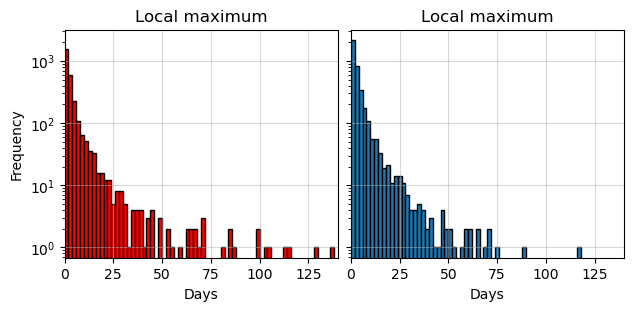

In [ ]:
fig, ax = plt.subplots(1,2,sharey=True,
    figsize=(6.2217,3),layout='constrained'
)
ax[0].hist(Days_max,range=[0,140],bins=70,log=True,edgecolor='black',color='red')
ax[0].grid(alpha=0.5)
ax[0].set_xlim(0,140)
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Local maximum')

ax[1].hist(Days_min,range=[0,140],bins=70,log=True,edgecolor='black')
ax[1].grid(alpha=0.5)
ax[1].set_xlim(0,140)
ax[1].set_xlabel('Days')
ax[1].set_title('Local minimum')

fig.savefig(f'/nird/home/ekv036/MSc/Fig/EddyDuration',dpi=300, facecolor='w', edgecolor='w',
            orientation='landscape', format=None,
            transparent=False, bbox_inches=None,pad_inches=0.25)

In [ ]:
steps = np.arange(np.max(locMin['ID'].values))
Days_pos = [[] for i in steps]
for ID,LAT,LON,TIME in zip(locMax['ID'],locMax['Latitude'],locMax['Longitude'],locMax['Time']):
    Days_pos[int(ID)-1].append([LON,LAT,TIME])
for ID,LAT,LON,TIME in zip(locMin['ID'],locMin['Latitude'],locMin['Longitude'],locMin['Time']):
    Days_pos[int(ID)-1].append([LON,LAT,TIME])

display(Days_pos)

[[[-9.051355615000006, 71.07944607, 0],
  [-8.964615635000005, 71.07944607, 1],
  [-8.964615635000005, 71.09734426, 2],
  [-8.921229190000004, 71.115277835, 3],
  [-8.747566299999999, 71.09734426, 4],
  [-8.617187219999996, 71.09734426, 5],
  [-8.617187219999996, 71.09734426, 6],
  [-8.617187219999996, 71.09734426, 9]],
 [[-14.804034194999986, 71.24183117499999, 0],
  [-14.804034194999986, 71.24183117499999, 1],
  [-14.759311549999984, 71.24183117499999, 2],
  [-14.804034194999986, 71.24183117499999, 3],
  [-14.759311549999984, 71.27832667499999, 4],
  [-14.491640929999988, 71.24183117499999, 6],
  [-14.536175374999983, 71.24183117499999, 7],
  [-14.536175374999983, 71.22364068499999, 8],
  [-14.536175374999983, 71.26005971999999, 9],
  [-14.491640929999988, 71.24183117499999, 10],
  [-14.491640929999988, 71.26005971999999, 11],
  [-14.669962799999986, 71.24183117499999, 12],
  [-14.669962799999986, 71.24183117499999, 13],
  [-14.759311549999984, 71.24183117499999, 14],
  [-14.66996279

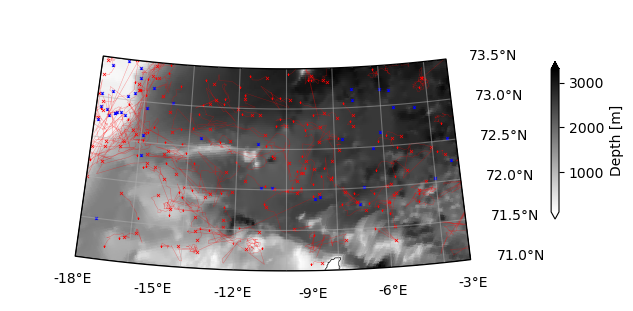

In [ ]:
warm = np.max(locMax['ID'].values)
fig, ax = plt.subplots(
    figsize=(6.2217,3), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-10)}, layout='constrained'
)

extent = [-18+10, -3+10, 71, 73.5]

mesh = ax.pcolormesh(depth.X, depth.Y, depth, cmap='binary', transform=ccrs.PlateCarree())
cbar = fig.colorbar(mesh, shrink=0.6, pad=0.005, extend='both')
cbar.set_label('Depth [m]')
ax.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], linewidths=0.5, colors='black', transform=ccrs.PlateCarree())

for ID,data in enumerate(Days_pos):
    if FWC[data[0][2]].sel(Y=data[0][1],method='nearest').sel(X=data[0][0],method='nearest') < 1.25:
        continue

    if len(data) < 6:
        continue

    if ID <= warm:
        data_x = []
        data_y = []
        for i,subdata in enumerate(data):
            if i != 0 and subdata[2] <= data[i-1][2]:
                continue
            data_x.append(subdata[0])
            data_y.append(subdata[1])
        ax.plot(data_x,data_y,color='r',linewidth=0.25,alpha=0.5, transform=ccrs.PlateCarree())
        ax.plot(data_x[0],data_y[0],marker='v',color='r',markersize=0.5, transform=ccrs.PlateCarree())
        ax.scatter(data_x[-1],data_y[-1],marker='x',s=5,linewidths=0.5,color='r', transform=ccrs.PlateCarree())
    else:
        data_x = []
        data_y = []
        for i,subdata in enumerate(data):
            if i != 0 and subdata[2] <= data[i][2]:
                continue
            data_x.append(subdata[0])
            data_y.append(subdata[1])
        ax.plot(data_x,data_y,color='b',linewidth=0.25,alpha=0.5, transform=ccrs.PlateCarree())
        ax.plot(data_x[0],data_y[0],marker='v',color='b',markersize=0.5, transform=ccrs.PlateCarree())
        ax.scatter(data_x[-1],data_y[-1],marker='x',s=5,linewidths=0.5,color='b', transform=ccrs.PlateCarree())

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

# Add gridlines without labels
gl = ax.gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 3)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 0.5, 0.5)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    ax.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=10, ha='center', va='top')

# Add right labels
for ytick in yticks:
    ax.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=10, ha='left', va='center')

fig.savefig(f'/nird/home/ekv036/MSc/Fig/EddyPath',dpi=300, facecolor='w', edgecolor='w',
            orientation='landscape', format=None,
            transparent=False, bbox_inches=None,pad_inches=0.25)

In [ ]:
ID_in_region = np.unique([np.nan])
ID_in_region = ID_in_region[~np.isnan(ID_in_region)]
if len(ID_in_region) == 0:
    print('Yes')

a = [1,2,3,6,5]
b = [7,8,0]

if any((A not in b for A in a)):
    print('YES')

Yes
YES
